# Cavern storage capacity

In [1]:
import importlib
import os
from zipfile import ZipFile

import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar
from pyfluids import Fluid, FluidsList, Input
import matplotlib as mpl

from src import functions as fns
from src import capacity as cap

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

## Halite data

In [3]:
ds, extent = fns.read_dat_file(dat_path=os.path.join("data", "kish-basin"))

In [4]:
xmin, ymin, xmax, ymax = extent.total_bounds

## Constraints

### Exploration wells

In [5]:
# 500 m buffer - suggested in draft OREDP II p. 108
wells, wells_b = fns.constraint_exploration_well(
    data_path=os.path.join(
        "data",
        "exploration-wells-irish-offshore",
        "Exploration_Wells_Irish_Offshore.shapezip.zip",
    )
)

### Wind farms

In [6]:
# the shapes are used as is without a buffer - suggested for renewable energy
# test site areas in draft OREDP II p. 109
wind_farms = fns.constraint_wind_farm(
    data_path=os.path.join(
        "data",
        "wind-farms-foreshore-process",
        "wind-farms-foreshore-process.zip",
    ),
    dat_extent=extent,
)

### Frequent shipping routes

In [7]:
# 1 NM (1,852 m) buffer - suggested in draft OREDP II p. 108
shipping, shipping_b = fns.constraint_shipping_routes(
    data_path=os.path.join(
        "data", "shipping", "shipping_frequently_used_routes.zip"
    ),
    dat_extent=extent,
)

### Shipwrecks

In [8]:
# Archaeological Exclusion Zones recommendation - 100 m buffer
shipwrecks, shipwrecks_b = fns.constraint_shipwrecks(
    data_path=os.path.join(
        "data", "heritage", "IE_GSI_MI_Shipwrecks_IE_Waters_WGS84_LAT.zip"
    ),
    dat_extent=extent,
)

### Subsea cables

In [9]:
# 750 m buffer - suggested in draft OREDP II p. 109-111
cables, cables_b = fns.constraint_subsea_cables(
    data_path=os.path.join("data", "kis-orca", "KIS-ORCA.gpkg")
)

### Distance from salt formation edge

In [10]:
edge_buffer = fns.constraint_halite_edge(dat_xr=ds)

## Zones of interest

In [11]:
# height = 85 m, 500 m <= depth <= 2,000 m, diameter = 80 m,
# separation = 320 m
zones, zds = fns.zones_of_interest(
    dat_xr=ds, constraints={"height": 85, "min_depth": 500, "max_depth": 2000}
)

## Generate caverns

In [12]:
caverns, caverns_excl = fns.generate_caverns_with_constraints(
    zones_gdf=zones,
    zones_ds=zds,
    dat_extent=extent,
    exclusions={
        "wells": wells_b,
        "wind_farms": wind_farms,
        "shipwrecks": shipwrecks_b,
        "shipping": shipping_b,
        "cables": cables_b,
        "edge": edge_buffer,
    },
)

Without constraints...
Number of potential caverns: 4,336
------------------------------------------------------------
Exclude exploration wells...
Number of potential caverns: 4,316
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 3,944
------------------------------------------------------------
Exclude shipwrecks...
Number of potential caverns: 3,941
------------------------------------------------------------
Exclude frequent shipping routes...
Number of potential caverns: 1,549
------------------------------------------------------------
Exclude subsea cables...
Number of potential caverns: 1,465
------------------------------------------------------------
Exclude salt formation edges...
Number of potential caverns: 1,390


In [13]:
# label caverns by height and depth
caverns = fns.label_caverns(
    cavern_df=caverns,
    heights=[85, 155, 311],
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

## Capacity

### Volume

In [14]:
caverns["cavern_volume"] = cap.cavern_volume(height=caverns["cavern_height"])

### Mid-point temperature

In [15]:
caverns["t_mid_point"] = cap.temperature_cavern_mid_point(
    height=caverns["cavern_height"], depth_top=caverns["cavern_depth"]
)

### Operating pressure

In [16]:
(
    caverns["p_operating_min"],
    caverns["p_operating_max"],
) = cap.pressure_operating(thickness_overburden=caverns["TopDepth"])

### Hydrogen gas density

In [17]:
caverns["rho_min"], caverns["rho_max"] = cap.density_hydrogen_gas(
    p_operating_min=caverns["p_operating_min"],
    p_operating_max=caverns["p_operating_max"],
    t_mid_point=caverns["t_mid_point"],
)

### Working mass of hydrogen

In [18]:
caverns["working_mass"] = cap.mass_hydrogen_working(
    rho_h2_min=caverns["rho_min"],
    rho_h2_max=caverns["rho_max"],
    v_cavern=caverns["cavern_volume"],
)

### Energy storage capacity in GWh

In [19]:
caverns["capacity"] = cap.energy_storage_capacity(
    m_working=caverns["working_mass"]
)

## Stats

In [20]:
caverns.drop(["x", "y", "TopTWT", "BaseDepth"], axis=1).describe()

,Thickness,TopDepth,cavern_height,cavern_depth,cavern_volume,t_mid_point,p_operating_min,p_operating_max,rho_min,rho_max,working_mass,capacity
count,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1.390000e+03,1.390000e+03,1390.000000,1390.000000,1.390000e+03,1390.000000
mean,301.271103,1032.944181,151.434532,1112.944181,317868.478887,42.093859,7.619621e+06,2.031899e+07,3.103646,7.908566,1.570086e+06,52.318756
std,82.154311,417.252534,64.388767,417.252534,155027.475670,11.405296,2.947138e+06,7.859035e+06,1.042668,2.563084,9.926002e+05,33.075645
min,175.062400,420.019200,85.000000,500.019200,157915.456354,24.651212,3.290410e+06,8.774426e+06,1.379869,3.611893,3.526407e+05,11.750771
25%,235.347600,695.388100,85.000000,775.388100,157915.456354,32.767462,5.235395e+06,1.396105e+07,2.130044,5.520515,8.339329e+05,27.788497
50%,291.285400,966.166300,155.000000,1046.166300,326452.980096,40.308688,7.147956e+06,1.906122e+07,3.121601,7.986693,1.458064e+06,48.585917
75%,353.398775,1361.360500,155.000000,1441.360500,326452.980096,51.019427,9.939291e+06,2.650478e+07,3.957457,10.017706,2.001093e+06,66.680872
max,754.985800,1917.627900,311.000000,1997.627900,702050.890150,66.785161,1.386832e+07,3.698219e+07,5.255584,13.089677,5.374345e+06,179.085123


In [21]:
# cavern volumes
list(caverns["cavern_volume"].unique())

[702050.8901495441, 326452.98009604175, 157915.45635408553]

In [22]:
# total capacity
caverns[["capacity"]].sum().iloc[0]

72723.07038248348

In [23]:
# total capacity at different cavern heights
s = (
    caverns.sort_values("Thickness")
    .groupby("height", sort=False)[["capacity"]]
    .sum()
)
s["%"] = s["capacity"] / caverns[["capacity"]].sum().iloc[0] * 100
s

,capacity,%
height,,
85,9481.668523,13.038048
155,44196.230611,60.773329
311,19045.171248,26.188624


In [24]:
# total capacity at different cavern depths
s = (
    caverns.sort_values("TopDepth")
    .groupby("depth", sort=False)[["capacity"]]
    .sum()
)
s["%"] = s["capacity"] / caverns[["capacity"]].sum().iloc[0] * 100
s

,capacity,%
depth,,
"500 - 1,000",25459.728067,35.009149
"1,000 - 1,500",27059.345112,37.208750
"1,500 - 2,000",20203.997204,27.782101


In [25]:
# total capacity at various depth/height combinations
s = caverns.groupby(["height", "depth"], sort=False)[["capacity"]].sum()
s["%"] = s["capacity"] / caverns[["capacity"]].sum().iloc[0] * 100
s

capacity          %
height depth                                 
311    1,000 - 1,500   8363.962530  11.501113
       500 - 1,000     3541.994649   4.870524
       1,500 - 2,000   7139.214069   9.816987
155    1,000 - 1,500  16565.174442  22.778431
       1,500 - 2,000  10302.372296  14.166580
       500 - 1,000    17328.683874  23.828317
85     1,000 - 1,500   2130.208140   2.929205
       1,500 - 2,000   2762.410839   3.798534
       500 - 1,000     4589.049544   6.310308

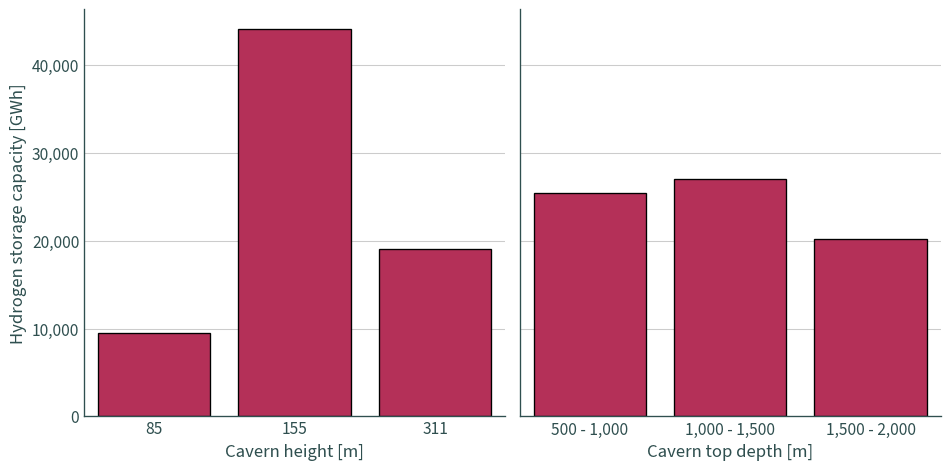

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.barplot(
    s.groupby("height").sum(),
    x="height",
    y="capacity",
    edgecolor="black",
    ax=axes[0],
    order=["85", "155", "311"],
    color=sns.color_palette("rocket", 256)[127],
    errorbar=None,
)
sns.barplot(
    s.groupby("depth").sum(),
    x="depth",
    y="capacity",
    edgecolor="black",
    ax=axes[1],
    order=["500 - 1,000", "1,000 - 1,500", "1,500 - 2,000"],
    color=sns.color_palette("rocket", 256)[127],
    errorbar=None,
)
axes[0].set_xlabel("Cavern height [m]")
axes[1].set_xlabel("Cavern top depth [m]")
axes[0].grid(which="major", axis="y")
axes[1].grid(which="major", axis="y")
axes[0].set_ylabel("Hydrogen storage capacity [GWh]")
axes[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
sns.despine()
plt.tight_layout()
plt.show()

## Maps

In [27]:
# create exclusion buffer
buffer = pd.concat([wells_b, shipwrecks_b, shipping_b, cables_b]).dissolve()

In [28]:
def plot_map_alt(dat_xr, cavern_df, zones_gdf, class_int):
    """
    Helper function to plot caverns within the zones of interest
    """

    plt.figure(figsize=(20, 11.5))
    axis = plt.axes(projection=ccrs.epsg(fns.CRS))
    legend_handles = []

    # halite boundary - use buffering to smooth the outline
    shape = fns.halite_shape(dat_xr=dat_xr).buffer(1000).buffer(-1000)
    shape.plot(
        ax=axis,
        edgecolor="darkslategrey",
        color="none",
        linewidth=2,
        alpha=0.5,
        zorder=2,
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            linewidth=2,
            edgecolor="darkslategrey",
            label="Kish Basin boundary",
            alpha=0.5,
        )
    )

    zones_gdf.plot(
        ax=axis, zorder=1, linewidth=0, facecolor="white", alpha=0.45
    )
    zones_gdf.plot(
        ax=axis,
        zorder=2,
        edgecolor="slategrey",
        linestyle="dotted",
        linewidth=1.25,
        facecolor="none",
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            linestyle="dotted",
            edgecolor="slategrey",
            label="Feasible area",
            linewidth=1.25,
        )
    )

    pd.concat([buffer, wind_farms]).dissolve().clip(shape).plot(
        ax=axis,
        facecolor="none",
        linewidth=0.65,
        edgecolor="slategrey",
        zorder=2,
        alpha=0.5,
        hatch="//",
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            hatch="//",
            edgecolor="slategrey",
            label="Exclusion area",
            alpha=0.65,
            linewidth=0.5,
        )
    )

    legend_handles.append(
        mpatches.Patch(
            label="Hydrogen storage \ncapacity [GWh]", visible=False
        )
    )

    for x, y, z in zip(
        [0 + class_int * n for n in range(5)],
        [0] + [int(256 / 4) + int(256 / 4) * n - 1 for n in range(4)],
        [
            f"< {class_int}",
            f"{class_int} - {class_int * 2}",
            f"{class_int * 2} - {class_int * 3}",
            f"{class_int * 3} - {class_int * 4}",
            f"≥ {class_int * 4}",
        ],
    ):
        if x == 0:
            c = cavern_df[cavern_df["capacity"] < x + 40]
        elif x == 160:
            c = cavern_df[cavern_df["capacity"] >= x]
        else:
            c = cavern_df[
                (cavern_df["capacity"] >= x) & (cavern_df["capacity"] < x + 40)
            ]
        for df, markersize in zip(
            [
                c[c["depth"] == "500 - 1,000"],
                c[c["depth"] == "1,000 - 1,500"],
                c[c["depth"] == "1,500 - 2,000"],
            ],
            [20, 50, 20],
        ):
            if len(df) > 0:
                df.centroid.plot(
                    ax=axis,
                    zorder=3,
                    linewidth=0,
                    marker=".",
                    markersize=markersize,
                    color=sns.color_palette("flare", 256)[y],
                )
        legend_handles.append(
            mpatches.Patch(
                facecolor=sns.color_palette("flare", 256)[y], label=z
            )
        )

    legend_handles.append(
        mpatches.Patch(label="Cavern top depth [m]", visible=False)
    )
    for markersize, label in zip(
        [6, 3], ["1,000 - 1,500", "500 - 1,000 or \n1,500 - 2,000"]
    ):
        legend_handles.append(
            Line2D(
                [0],
                [0],
                marker=".",
                linewidth=0,
                label=label,
                color="darkslategrey",
                markersize=markersize,
            )
        )

    plt.xlim(shape.bounds["minx"][0] - 1000, shape.bounds["maxx"][0] + 1000)
    plt.ylim(shape.bounds["miny"][0] - 1000, shape.bounds["maxy"][0] + 1000)

    cx.add_basemap(
        axis, crs=fns.CRS, source=cx.providers.CartoDB.VoyagerNoLabels
    )
    axis.gridlines(
        draw_labels={"bottom": "x", "left": "y"},
        alpha=0.25,
        color="darkslategrey",
    )
    axis.add_artist(
        ScaleBar(1, box_alpha=0, location="lower right", color="darkslategrey")
    )
    plt.legend(
        loc="lower right", bbox_to_anchor=(1, 0.05), handles=legend_handles
    )

    plt.tight_layout()
    plt.show()

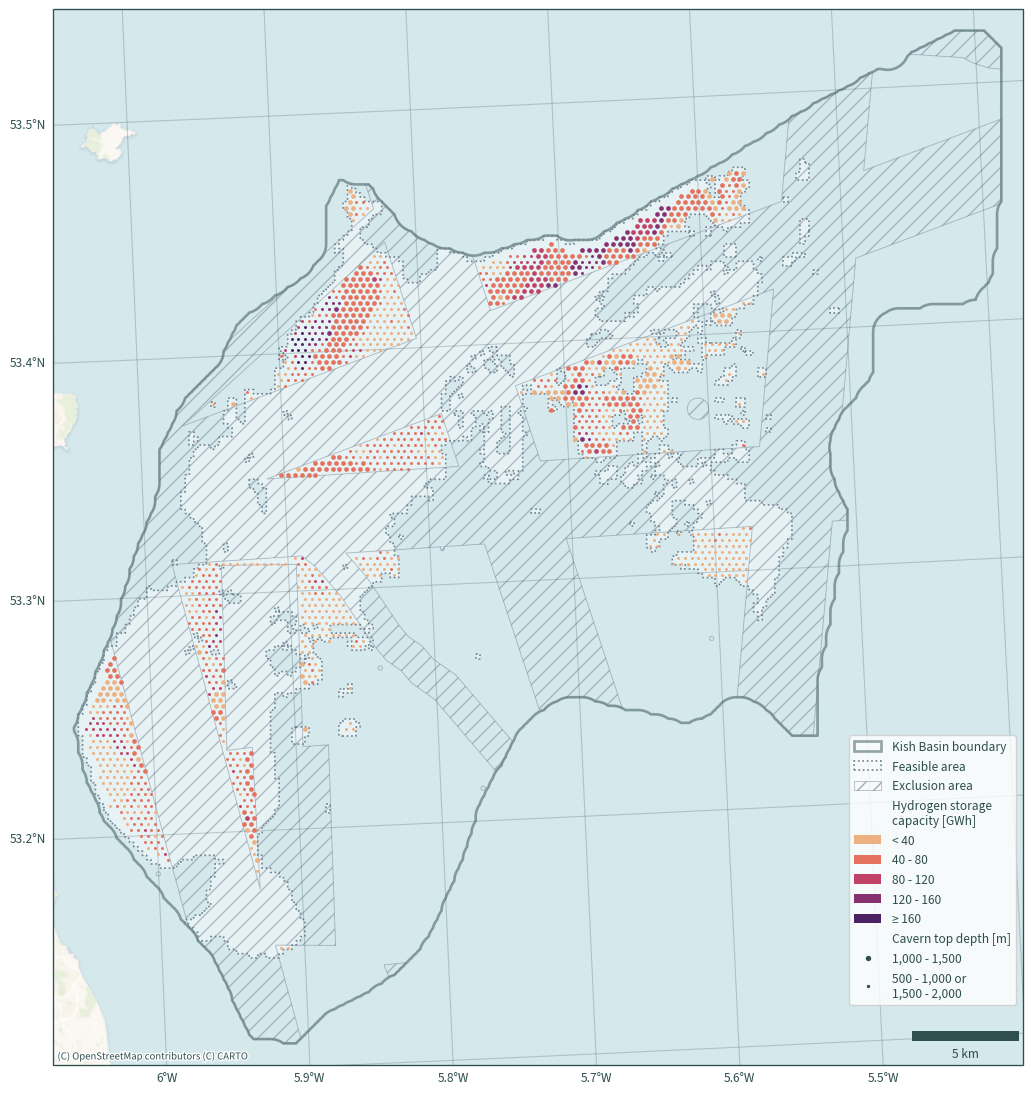

In [29]:
plot_map_alt(ds, caverns, zones, 40)

## Restrict cavern height to 155 m

In [30]:
# height = 85 m, 500 m <= depth <= 2,000 m, diameter = 80 m,
# separation = 320 m
zones, zds = fns.zones_of_interest(
    dat_xr=ds, constraints={"height": 155, "min_depth": 500, "max_depth": 2000}
)

In [31]:
caverns, caverns_excl = fns.generate_caverns_with_constraints(
    zones_gdf=zones,
    zones_ds=zds,
    dat_extent=extent,
    exclusions={
        "wells": wells_b,
        "wind_farms": wind_farms,
        "shipwrecks": shipwrecks_b,
        "shipping": shipping_b,
        "cables": cables_b,
        "edge": edge_buffer,
    },
)

Without constraints...
Number of potential caverns: 2,585
------------------------------------------------------------
Exclude exploration wells...
Number of potential caverns: 2,579
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 2,410
------------------------------------------------------------
Exclude shipwrecks...
Number of potential caverns: 2,408
------------------------------------------------------------
Exclude frequent shipping routes...
Number of potential caverns: 943
------------------------------------------------------------
Exclude subsea cables...
Number of potential caverns: 924
------------------------------------------------------------
Exclude salt formation edges...
Number of potential caverns: 872


In [32]:
# label caverns by height and depth
caverns = fns.label_caverns(
    cavern_df=caverns,
    heights=[155],
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

In [33]:
caverns["cavern_volume"] = cap.cavern_volume(height=caverns["cavern_height"])

caverns["t_mid_point"] = cap.temperature_cavern_mid_point(
    height=caverns["cavern_height"], depth_top=caverns["cavern_depth"]
)

(
    caverns["p_operating_min"],
    caverns["p_operating_max"],
) = cap.pressure_operating(thickness_overburden=caverns["TopDepth"])

caverns["rho_min"], caverns["rho_max"] = cap.density_hydrogen_gas(
    p_operating_min=caverns["p_operating_min"],
    p_operating_max=caverns["p_operating_max"],
    t_mid_point=caverns["t_mid_point"],
)

caverns["working_mass"] = cap.mass_hydrogen_working(
    rho_h2_min=caverns["rho_min"],
    rho_h2_max=caverns["rho_max"],
    v_cavern=caverns["cavern_volume"],
)

caverns["capacity"] = cap.energy_storage_capacity(
    m_working=caverns["working_mass"]
)

In [34]:
caverns.drop(["x", "y", "TopTWT", "BaseDepth"], axis=1).describe()

,Thickness,TopDepth,height,cavern_height,cavern_depth,cavern_volume,t_mid_point,p_operating_min,p_operating_max,rho_min,rho_max,working_mass,capacity
count,872.000000,872.000000,872.0,872.0,872.000000,872.000000,872.000000,8.720000e+02,8.720000e+02,872.000000,872.000000,8.720000e+02,872.000000
mean,344.954012,1052.441725,155.0,155.0,1132.441725,326452.980096,42.668427,7.757336e+06,2.068623e+07,3.237223,8.239192,1.632908e+06,54.412117
std,69.591682,405.399959,0.0,0.0,405.399959,0.000000,10.945799,2.863421e+06,7.635789e+06,0.997441,2.448593,4.737820e+05,15.787469
min,245.000700,420.243700,155.0,155.0,500.243700,326452.980096,25.599080,3.291995e+06,8.778654e+06,1.379869,3.611893,7.286508e+05,24.280264
25%,292.245250,708.436525,155.0,155.0,788.436525,326452.980096,33.380286,5.327559e+06,1.420682e+07,2.579825,6.647030,1.327751e+06,44.243616
50%,336.827850,1033.375550,155.0,155.0,1113.375550,326452.980096,42.153640,7.622668e+06,2.032712e+07,3.247637,8.295692,1.647952e+06,54.913438
75%,380.678425,1362.374925,155.0,155.0,1442.374925,326452.980096,51.036623,9.946457e+06,2.652388e+07,4.027104,10.184985,2.010259e+06,66.986289
max,754.985800,1906.220200,155.0,155.0,1986.220200,326452.980096,65.720445,1.378774e+07,3.676732e+07,5.199740,12.959501,2.533197e+06,84.411758


In [35]:
# cavern volumes
list(caverns["cavern_volume"].unique())

[326452.98009604175]

In [36]:
# total capacity
caverns[["capacity"]].sum().iloc[0]

47447.36575438888

In [37]:
# total capacity at various depth/height combinations
s = caverns.groupby(["height", "depth"], sort=False)[["capacity"]].sum()
s["%"] = s["capacity"] / caverns[["capacity"]].sum().iloc[0] * 100
s

capacity          %
height depth                                 
155    1,000 - 1,500  18524.241892  39.041666
       500 - 1,000    16625.790392  35.040492
       1,500 - 2,000  12297.333470  25.917842

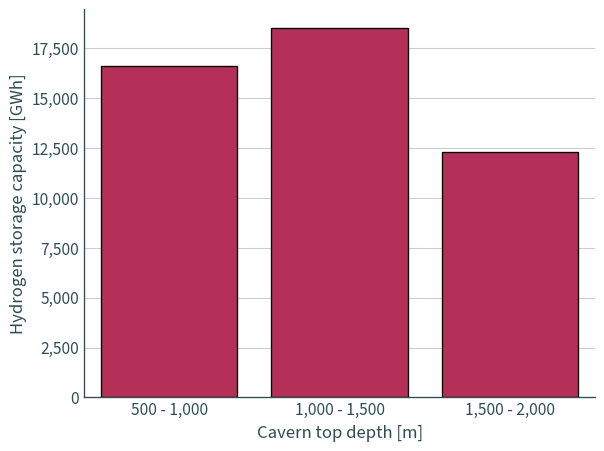

In [38]:
ax = sns.barplot(
    s.groupby("depth").sum(),
    x="depth",
    y="capacity",
    edgecolor="black",
    order=["500 - 1,000", "1,000 - 1,500", "1,500 - 2,000"],
    color=sns.color_palette("rocket", 256)[127],
    errorbar=None,
)
ax.set_xlabel("Cavern top depth [m]")
ax.grid(which="major", axis="y")
ax.set_ylabel("Hydrogen storage capacity [GWh]")
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
sns.despine()
plt.tight_layout()
plt.show()

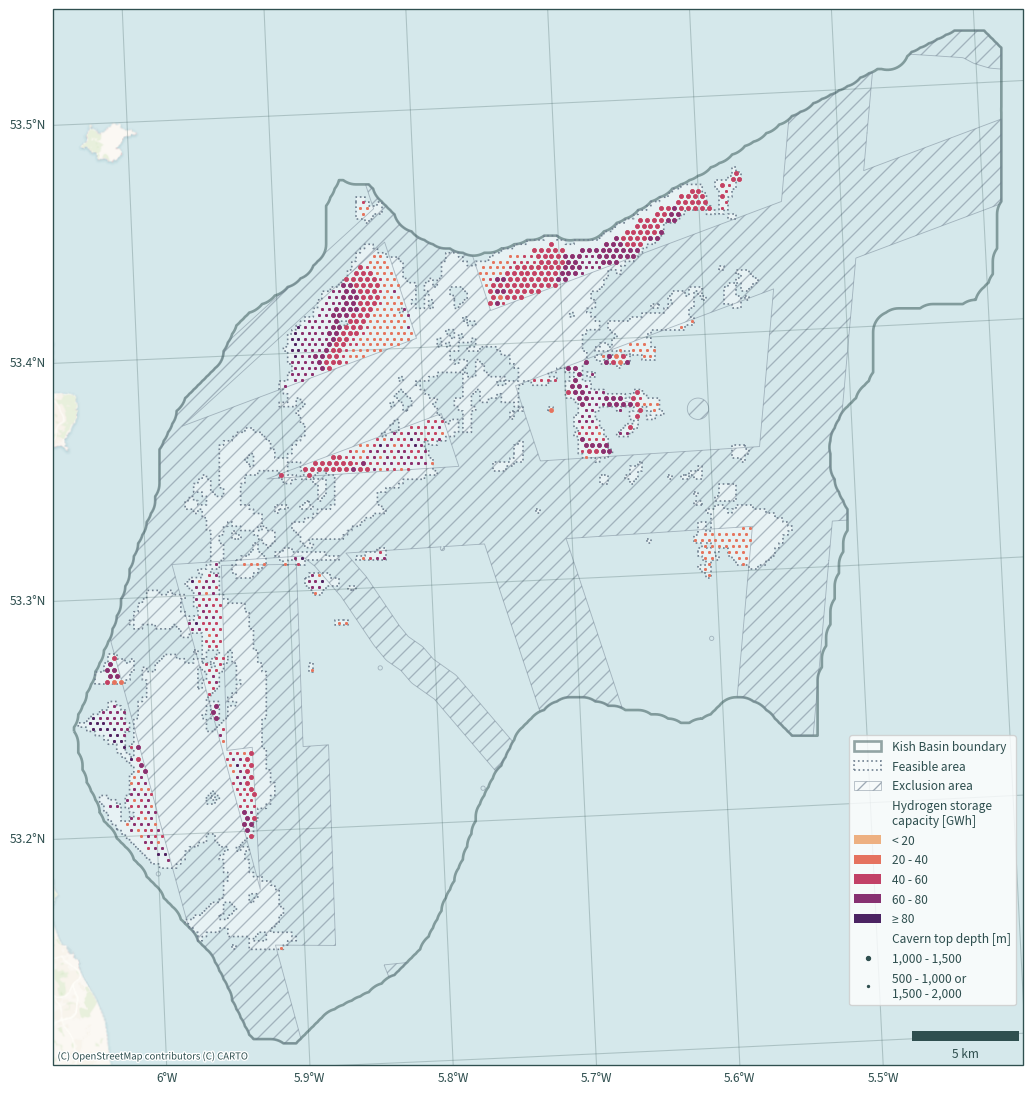

In [39]:
plot_map_alt(ds, caverns, zones, 20)